<a href="https://colab.research.google.com/github/Panaxnotoginseng/Exercise-3/blob/main/Exercise_3_Percent_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import urllib.parse
from tqdm import tqdm # for showing progress

words = open('More Chinese Names.txt', 'r', encoding='utf-8-sig').read().splitlines() # read all the names
chars = sorted(list(set(''.join(urllib.parse.quote(str(words)))))) # convert each name to its percent encoding and build a list of characters appeared and mappings to/from integers
stoi = {s:i+1 for i,s in enumerate(chars)} # assign a number to each character
stoi['.'] = 0 # assign 0 to dot
itos = {i:s for s,i in stoi.items()} #create a dictionary that contains all the characters and corresponding number
print(itos)

{1: '%', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'A', 13: 'B', 14: 'C', 15: 'D', 16: 'E', 17: 'F', 0: '.'}


In [2]:
# build the dataset

block_size = 28 # Take 28 characters to make prediction

X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
for w in urllib.parse.quote(str(words))[:20]: # take 20 names
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context) # the running context
    Y.append(ix) # the index of X
    context = context[1:] + [ix] # crop the context and append a new character in the sequence

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape) # from 20 names we get 40 examples (depending on name length). 28 input at each time.

torch.Size([40, 28]) torch.Size([40])


In [3]:
def build_dataset(words):
  X, Y = [], [] #X is the input of the neural network, Y is the label of each example in X
  for w in tqdm(words):
    context = [0] * block_size #initialize with all dots
    for ch in urllib.parse.quote(str(w)) + '.':
      ix = stoi[ch]
      X.append(context) # the running context
      Y.append(ix) # the index of X
      context = context[1:] + [ix] # crop the context and append a new character in the sequence

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# separate datasets
Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) #test set

100%|██████████| 80000/80000 [00:06<00:00, 13266.05it/s]


torch.Size([2125988, 28]) torch.Size([2125988])


100%|██████████| 10000/10000 [00:00<00:00, 12363.35it/s]


torch.Size([265303, 28]) torch.Size([265303])


100%|██████████| 10000/10000 [00:00<00:00, 16714.58it/s]


torch.Size([265870, 28]) torch.Size([265870])


In [4]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((18, 2), generator=g) # embed 18 different characters in 2 dimentional space
W1 = torch.randn((56, 200), generator=g) #set hidden layer with 56 inputs and 200 neurons
b1 = torch.randn(200, generator=g) # set bias for the 200 neurons in hidden layer
W2 = torch.randn((200, 18), generator=g) #set output layer with 200 inputs and 18 neurons
b2 = torch.randn(18, generator=g) # set bias for the 18 neurons in output layer

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True # make sure all parameters have gradient


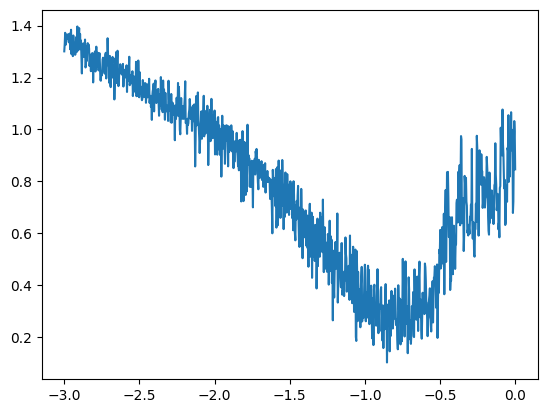

In [5]:
# find proper learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []


for i in range(1000):

  # construct minibatches of 72 examples
  ix = torch.randint(0, Xtr.shape[0], (72,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 56) @ W1 + b1) #
  logits = h @ W2 + b2 #
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  #track status
  lri.append(lre[i])
  lossi.append(loss.log10().item())

plt.plot(lri,lossi) # exponent of the best learning rate is around -1, 10 to -1 is about 0.1

In [7]:
# training
from tqdm import tqdm
for i in tqdm(range(300000)):

  # construct minibatches of 80 examples
  ix = torch.randint(0, Xtr.shape[0], (80,))

  # forward pass
  emb = C[Xtr[ix]] # (80, 4, 10)
  h = torch.tanh(emb.view(-1, 56) @ W1 + b1) # (80, 100)
  logits = h @ W2 + b2 # (80, 687) outcomes
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None # set gradient to 0 every time
  loss.backward()

  # update parameters
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

100%|██████████| 300000/300000 [05:11<00:00, 964.44it/s] 

0.9225942492485046


In [8]:
# test on validation set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 56) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(1.0108, grad_fn=<NllLossBackward0>)


In [9]:
# test on test set
emb = C[Xte]
h = torch.tanh(emb.view(-1, 56) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss)

tensor(1.0071, grad_fn=<NllLossBackward0>)


In [10]:
!pip install zhconv # convert percent encoding back to hanzi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for zhconv: filename=zhconv-1.4.3-py2.py3-none-any.whl size=208849 sha256=8128ef259c00232dcc3db4295545cb6c242f7cf3ef0f5f485b0e90c395f05bb7
  Stored in directory: /root/.cache/pip/wheels/68/73/ff/95fe3e7b41a545b9701416c2178b920713b33022c3d605bdb4
Successfully built zhconv


In [14]:
# generate names
import zhconv
g = torch.Generator().manual_seed(2147497997) # for reproducibility

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all dots
    while True:
      emb = C[torch.tensor([context])] # (single example,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # normalized probability
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0: #generating a dot means the name ends
        break

    print(zhconv.convert(urllib.parse.unquote(str(''.join(itos[i] for i in out))),'zh-hans'))

吲𫄨.
滦巆.
晾漗䰠.
樵霰到.
橍募.
珿胰花.
佩绰噗.
斱滊吸.
竬夒.
崸箱庁.
蟆䅺.
京诊帾.
俫滣拯.
斎氱枉.
昽偓朱.
晈皣濥.
溢嘭䷀.
譧舵.
頞浰.
厇嵃玹.
